In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy
from scipy.sparse import hstack

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score,f1_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer # change Ving to original verb
import string

# ignore warnings
pd.options.mode.chained_assignment = None # default='warn'
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=UserWarning)

In [2]:
# pd.set_option('display.max_columns', None)
np.set_printoptions(threshold = np.inf)
# pd.set_option('display.max_colwidth', None)

In [3]:
# import the training and evaluation dataset
train = pd.read_csv('TMDB_train.csv')
evaluate = pd.read_csv('TMDB_evaluate.csv')

# target lables
y_train = train['rate_category']
y_eval = evaluate['rate_category']

# concat the training and evaluation sets together for pre-processing
concat_df = pd.concat([train, evaluate], axis=0)
concat_df.head()

,id,title,release_year,overview,tagline,runtime,budget,revenue,adult,original_language,...,product_of_India,product_of_Italy,product_of_Japan,product_of_Spain,product_of_UK,product_of_USA,product_of_other_countries,vote_count,rate_category,average_rate
0,504314,Sudani from Nigeria,2018,When a soccer club manager brings one of his i...,NaN,123,0,3585800,False,ml,...,1,0,0,0,0,0,0,29,4,7.200
1,46762,The Takers,1971,"After a breakfast of LSD and hitchhikers, The ...",...holding women at their mercy - helpless to ...,81,0,0,False,en,...,0,0,0,0,0,1,0,4,0,4.000
2,24253,The Girl Who Played with Fire,2009,"Mikael Blomkvist, publisher of Millennium maga...",Fight Fire with Fire,130,4422952,67126795,False,sv,...,0,0,0,0,0,0,3,1515,3,6.995
3,794530,Stripped,2016,A true story: An unconventional mother on the ...,A mother's love is all that's left.,12,0,0,False,en,...,0,0,0,0,1,1,0,3,1,5.000
4,697197,La perruque,1905,While the old gentleman is dying his mustache ...,NaN,2,0,0,False,en,...,0,0,0,0,0,0,0,1,1,5.000


# Pre-processing text features

In [6]:
# extract the text features
df = concat_df[['title', 'overview', 'tagline', 'production_companies']]

# fill the missing value with blank
df.fillna('', inplace = True)

In [7]:
# import the packages for removing stop words and punctuation and lemmatizing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [8]:
# load stopwords
stop_words = stopwords.words('english')
# initialize lemmatizer
lem = WordNetLemmatizer()

def clean_text(text):
    # tokenize the text
    tokens = word_tokenize(text)
    # convert the tokens to lowercase
    tokens = [word.lower() for word in tokens]
    # remove stopwords and single characters
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    # remove punctuation
    tokens = [word for word in tokens if word not in set(string.punctuation)]
    # lemmatization
    tokens = [lem.lemmatize(word) for word in tokens]
    # keep only alphabet and number
    tokens = [word for word in tokens if word.isalnum()]
    # concat the tokens to a sentence
    return ' '.join(tokens)

In [9]:
# concat all the texts into one sentence
df['text'] = df['title'] + ' ' + df['overview'] + ' ' + df['tagline'] + ' ' + df['production_companies']
df = df['text']
df = df.reset_index().drop(columns = ['index'])
df.columns = ["text"]

In [10]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
df.head()

,text
0,sudani nigeria soccer club manager brings one ...
1,taker breakfast lsd hitchhiker taker two berse...
2,girl played fire mikael blomkvist publisher mi...
3,stripped true story unconventional mother run ...
4,la perruque old gentleman dying mustache eyebr...


In [11]:
# built the dictionary of word and the frequency of that word
def count_dict(sentence, vocab_dict):
  for word in sentence.split(' '):
    vocab_dict[word] = vocab_dict.get(word, 0) + 1

In [12]:
vocab_dict = {}
df['text'].apply(lambda x: count_dict(x, vocab_dict))
print('Number of unique words:', len(vocab_dict))

Number of unique words: 150671


In [13]:
# sort the dictionary according to the frequency of each word
vocab_dict = {k: v for k, v in sorted(vocab_dict.items(), key=lambda item: item[1], reverse=True)}

# only keep 1/5 of the most frequent words in the dataset
vocab = list(vocab_dict.keys())[:len(vocab_dict)//5]

# function for keeping the selected words
def keep_word(sentence, vocab):
  filtered = [word for word in sentence.split(' ') if word in vocab]
  return ' '.join(filtered)

In [14]:
# filtering the words which appear less frequently
df['text'] = df['text'].apply(lambda x: keep_word(x, vocab))
df.head()

,text
0,nigeria soccer club manager brings one injured...
1,taker breakfast lsd hitchhiker taker two berse...
2,girl played fire mikael blomkvist publisher mi...
3,stripped true story unconventional mother run ...
4,la old gentleman dying mustache eyebrow puttin...


In [15]:
# save the cleaned text, just in case
# df = pd.read_csv('cleaned.csv')

In [16]:
# use TF-IDF to vectorize the text
tfidf_vect = TfidfVectorizer()
X = tfidf_vect.fit_transform(df['text'])

# split the dataset into training and evaluation sets
X_train = X[:len(train)]
X_eval = X[len(train):]
print(X_train.shape, X_eval.shape)

(100000, 30121) (20000, 30121)


# Pre-processing release_year

In [17]:
# function for one-hot encoding release_year
def onehot_encoding(df):
    # declare the encoder
    onehot_encoder = OneHotEncoder(categories='auto', sparse_output=False)
    # encode the feature
    df = onehot_encoder.fit_transform(concat_df[['release_year']])
    return df[:len(train)], df[len(train):], onehot_encoder

In [18]:
onehot_train, onehot_eval, onehot_encoder = onehot_encoding(concat_df[['release_year']])
columns = onehot_encoder.get_feature_names_out(['release_year'])
onehot_train = pd.DataFrame(onehot_train, columns=columns)
onehot_eval = pd.DataFrame(onehot_eval, columns=columns)
onehot_train.head()

,release_year_1888,release_year_1890,release_year_1891,release_year_1892,release_year_1893,release_year_1894,release_year_1895,release_year_1896,release_year_1897,release_year_1898,...,release_year_2015,release_year_2016,release_year_2017,release_year_2018,release_year_2019,release_year_2020,release_year_2021,release_year_2022,release_year_2023,release_year_2024
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
print(onehot_train.shape, onehot_eval.shape)

(100000, 136) (20000, 136)


In [20]:
# convert the encoded release_year to sparse matrix
onehot_train = scipy.sparse.csr_matrix(onehot_train)
onehot_eval = scipy.sparse.csr_matrix(onehot_eval)
print(onehot_train.shape, onehot_eval.shape)

(100000, 136) (20000, 136)


In [21]:
# combine the text features and encoded release_year together
X_train_onehot = hstack((X_train, onehot_train))
X_eval_onehot = hstack((X_eval, onehot_eval))

print('Feature size with only test', X_train.shape, X_eval.shape)
print('Feature size with text and release_year', X_train_onehot.shape, X_eval_onehot.shape)

Feature size with only test (100000, 30121) (20000, 30121)
Feature size with text and release_year (100000, 30257) (20000, 30257)


# Models

## Baseline

In [22]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X_eval)
print('Zero-R accuracy:', dummy_clf.score(X_eval, y_eval))

Zero-R accuracy: 0.271


## Logistic regression

### Trained only on text feature

In [23]:
# train a logistic regression model
lgr1 = LogisticRegression(max_iter=100)
lgr1.fit(X_train, y_train)
y_pred = lgr1.predict(X_eval)

acc = accuracy_score(y_eval, y_pred)
f1 = f1_score(y_eval, y_pred, average=None)
precision = precision = precision_score(y_eval, y_pred, average=None)
recall = recall_score(y_eval, y_pred, average=None)

print("Accuracy:", acc)
print("FI-score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# get all the classes in the dataset and sort them
classes = [str(y) for y in y_train.unique()]
classes.sort()
print(classification_report(y_eval, y_pred, target_names=classes)) # support is how many samples in each class

Accuracy: 0.40185
FI-score: [0.29398374 0.28015929 0.44755015 0.47775615 0.27740058 0.30412165]
Precision: [0.50729517 0.41527778 0.38637331 0.39211741 0.42910728 0.45130641]
Recall: [0.20695971 0.21138211 0.53174448 0.61125461 0.20494446 0.22933011]
              precision    recall  f1-score   support

           0       0.51      0.21      0.29      2184
           1       0.42      0.21      0.28      2829
           2       0.39      0.53      0.45      5119
           3       0.39      0.61      0.48      5420
           4       0.43      0.20      0.28      2791
           5       0.45      0.23      0.30      1657

    accuracy                           0.40     20000
   macro avg       0.43      0.33      0.35     20000
weighted avg       0.42      0.40      0.38     20000



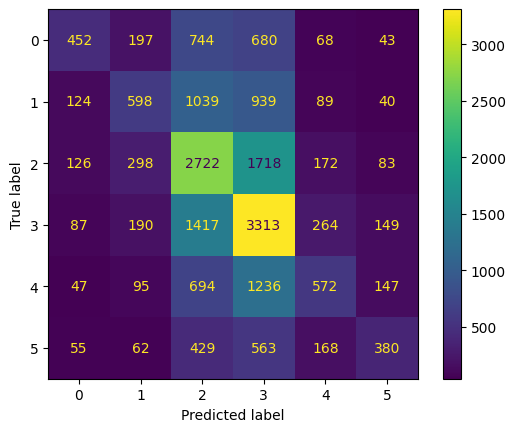

In [24]:
disp = ConfusionMatrixDisplay.from_estimator(lgr1, X_eval, y_eval)

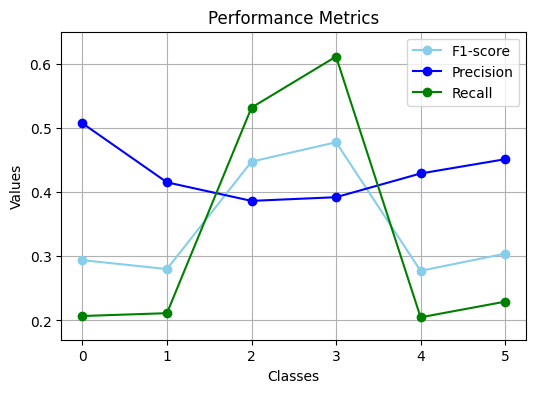

In [25]:
# plot of f1-score, precision and recall
plt.figure(figsize=(6, 4))
plt.plot(classes, f1, marker='o', color='skyblue', label='F1-score')
plt.plot(classes, precision, marker='o', color='blue', label='Precision')
plt.plot(classes, recall, marker='o', color='green', label='Recall')

plt.title('Performance Metrics')
plt.ylim(0.17, 0.65)
plt.xlabel('Classes')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

### Trained on release_year + text

In [ ]:
# train the logistic regression model on text features and one-hot encoded release_year
lgr2 = LogisticRegression(max_iter=100)
lgr2.fit(X_train_onehot, y_train)
y_pred = lgr2.predict(X_eval_onehot)

acc = accuracy_score(y_eval, y_pred)
f1 = f1_score(y_eval, y_pred, average=None)
precision = precision = precision_score(y_eval, y_pred, average=None)
recall = recall_score(y_eval, y_pred, average=None)

print("Accuracy:", acc)
print("FI-score:", f1)
print("Precision:", precision)
print("Recall:", recall)

print(classification_report(y_eval, y_pred, target_names=classes))

Accuracy: 0.38705
FI-score: [0.28806334 0.26632463 0.43347391 0.4573007  0.28432241 0.32591529]
Precision: [0.43       0.39136395 0.37582449 0.3914357  0.37217391 0.40212578]
Recall: [0.21657509 0.20183811 0.51201407 0.5498155  0.23002508 0.27398914]
              precision    recall  f1-score   support

           0       0.43      0.22      0.29      2184
           1       0.39      0.20      0.27      2829
           2       0.38      0.51      0.43      5119
           3       0.39      0.55      0.46      5420
           4       0.37      0.23      0.28      2791
           5       0.40      0.27      0.33      1657

    accuracy                           0.39     20000
   macro avg       0.39      0.33      0.34     20000
weighted avg       0.39      0.39      0.37     20000



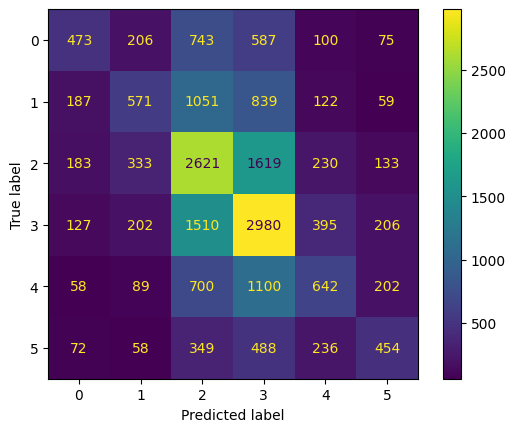

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(lgr2, X_eval_onehot, y_eval)

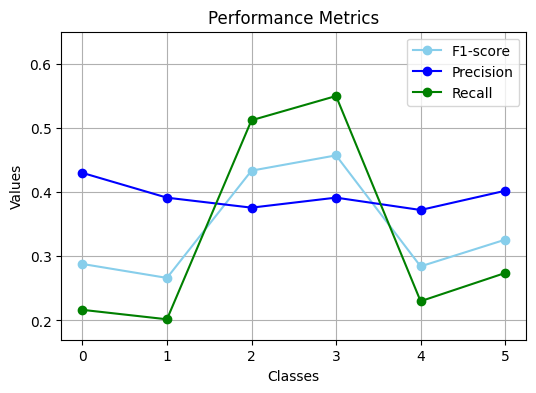

In [ ]:
# plot of f1-score, precision and recall
plt.figure(figsize=(6, 4))
plt.plot(classes, f1, marker='o', color='skyblue', label='F1-score')
plt.plot(classes, precision, marker='o', color='blue', label='Precision')
plt.plot(classes, recall, marker='o', color='green', label='Recall')

plt.title('Performance Metrics')
plt.ylim(0.17, 0.65)
plt.xlabel('Classes')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# use GridSearchCV to choose the optimal iteration times
from sklearn.model_selection import GridSearchCV
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

# define the parameter grid to search over
param_grid = {'max_iter': [250, 500, 750, 1000]}

# use GridSearchCV to find the best max_iter value
grid_search = GridSearchCV(lgr1, param_grid, cv=3)
grid_search.fit(X_train, y_train)

lgr_best = LogisticRegression(max_iter=grid_search.best_params_['max_iter'])
print("Best max_iter value:", grid_search.best_params_['max_iter'])
print("Accuracy:", grid_search.score(X_eval, y_eval))

Best max_iter value: 500
Accuracy: 0.40845


## MLP

In [ ]:
mlp_clf1 = MLPClassifier(hidden_layer_sizes=(64, 32),  # 2 hidden layers with 64 and 32 neurons respectively
                        activation='relu',  # activation function
                        solver='adam',  # optimization algorithm
                        learning_rate_init=0.001,  # initial learning rate
                        max_iter=100,  # maximum number of iterations
                        random_state=42)

# train the model
mlp_clf1.fit(X_train, y_train)
y_pred = mlp_clf1.predict(X_eval)

acc = accuracy_score(y_eval, y_pred)
f1 = f1_score(y_eval, y_pred, average=None)
precision = precision = precision_score(y_eval, y_pred, average=None)
recall = recall_score(y_eval, y_pred, average=None)

print("Accuracy:", acc)
print("FI-score:", f1)
print("Precision:", precision)
print("Recall:", recall)

print(classification_report(y_eval, y_pred, target_names=classes))

Accuracy: 0.63205
FI-score: [0.59377902 0.59864189 0.64943143 0.66642389 0.60901031 0.6086165 ]
Precision: [0.60216573 0.60534875 0.64622824 0.65780014 0.61513158 0.61195851]
Recall: [0.58562271 0.59208201 0.65266654 0.67527675 0.60300967 0.6053108 ]
              precision    recall  f1-score   support

           0       0.60      0.59      0.59      2184
           1       0.61      0.59      0.60      2829
           2       0.65      0.65      0.65      5119
           3       0.66      0.68      0.67      5420
           4       0.62      0.60      0.61      2791
           5       0.61      0.61      0.61      1657

    accuracy                           0.63     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.63      0.63      0.63     20000



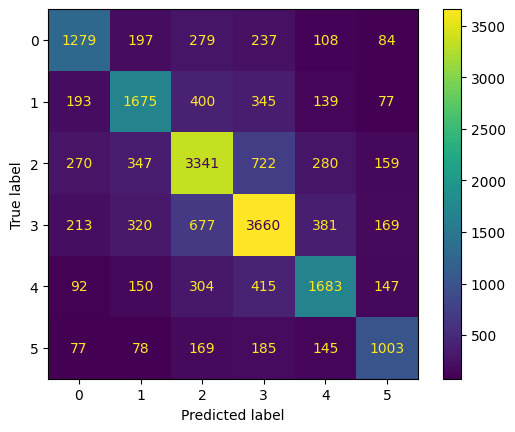

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(mlp_clf1, X_eval, y_eval)

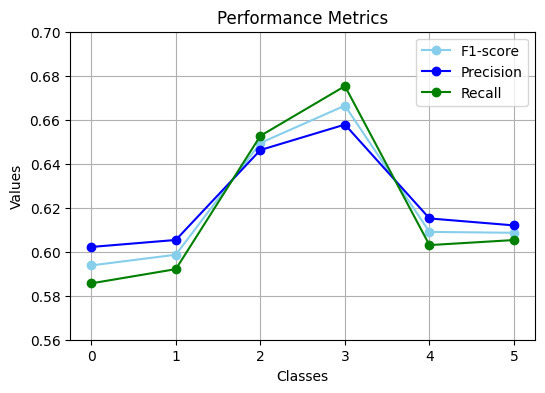

In [ ]:
# plot of f1-score, precision and recall
plt.figure(figsize=(6, 4))
plt.plot(classes, f1, marker='o', color='skyblue', label='F1-score')
plt.plot(classes, precision, marker='o', color='blue', label='Precision')
plt.plot(classes, recall, marker='o', color='green', label='Recall')

plt.title('Performance Metrics')
plt.ylim(0.56, 0.70)
plt.xlabel('Classes')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mlp_clf2 = MLPClassifier(hidden_layer_sizes=(64, 32),  # two hidden layers with 64 and 32 neurons respectively
                        activation='relu',  # activation function
                        solver='adam',  # optimization algorithm
                        learning_rate_init=0.001,  # initial learning rate
                        max_iter=100,  # maximum number of iterations
                        random_state=42)

# train the model
mlp_clf2.fit(X_train_onehot, y_train)
y_pred = mlp_clf2.predict(X_eval_onehot)

acc = accuracy_score(y_eval, y_pred)
f1 = f1_score(y_eval, y_pred, average=None)
precision = precision = precision_score(y_eval, y_pred, average=None)
recall = recall_score(y_eval, y_pred, average=None)

print("Accuracy:", acc)
print("FI-score:", f1)
print("Precision:", precision)
print("Recall:", recall)

classes = [str(y) for y in y_train.unique()]
classes.sort()
print(classification_report(y_eval, y_pred, target_names=classes))

Accuracy: 0.63355
FI-score: [0.5990271  0.60898916 0.64938847 0.66341553 0.60838019 0.6152477 ]
Precision: [0.60618847 0.61214286 0.64537912 0.66171072 0.61609111 0.6050175 ]
Recall: [0.59203297 0.6058678  0.65344794 0.66512915 0.60085991 0.62582981]
              precision    recall  f1-score   support

           0       0.61      0.59      0.60      2184
           1       0.61      0.61      0.61      2829
           2       0.65      0.65      0.65      5119
           3       0.66      0.67      0.66      5420
           4       0.62      0.60      0.61      2791
           5       0.61      0.63      0.62      1657

    accuracy                           0.63     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.63      0.63      0.63     20000



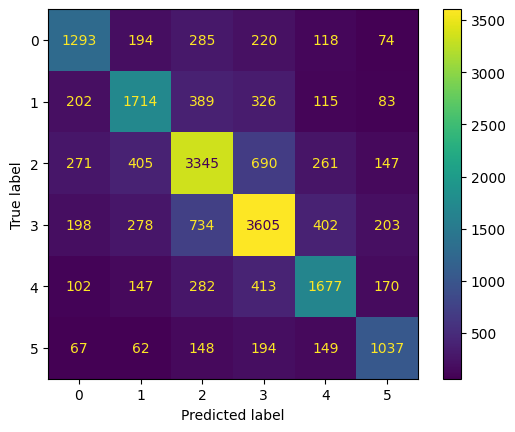

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(mlp_clf2, X_eval_onehot, y_eval)

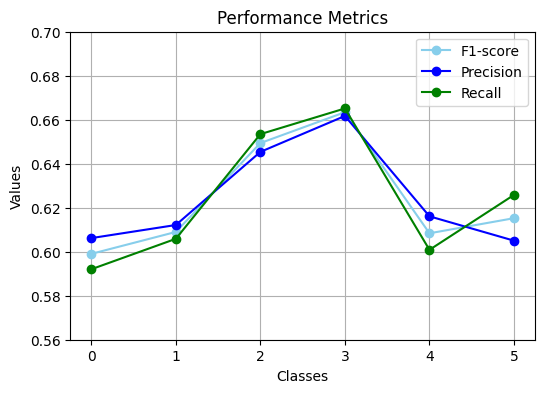

In [ ]:
# plot of f1-score, precision and recall
plt.figure(figsize=(6, 4))
plt.plot(classes, f1, marker='o', color='skyblue', label='F1-score')
plt.plot(classes, precision, marker='o', color='blue', label='Precision')
plt.plot(classes, recall, marker='o', color='green', label='Recall')

plt.title('Performance Metrics')
plt.ylim(0.56, 0.70)
plt.xlabel('Classes')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Other plots

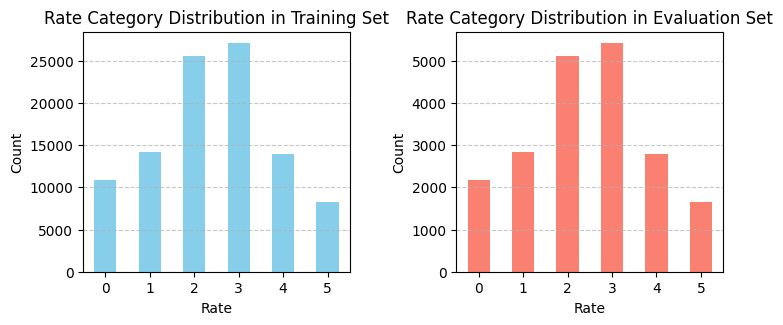

In [ ]:
# let's see the label distribution in training and evaluation set
rates_train = y_train.value_counts().sort_index()
rates_eval = y_eval.value_counts().sort_index()

plt.figure(figsize=(8, 3))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.subplot(1, 2, 1)
rates_train.plot(kind='bar', color='skyblue')
plt.title('Rate Category Distribution in Training Set')
plt.xlabel('Rate')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
rates_eval.plot(kind='bar', color='salmon')
plt.title('Rate Category Distribution in Evaluation Set')
plt.xlabel('Rate')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

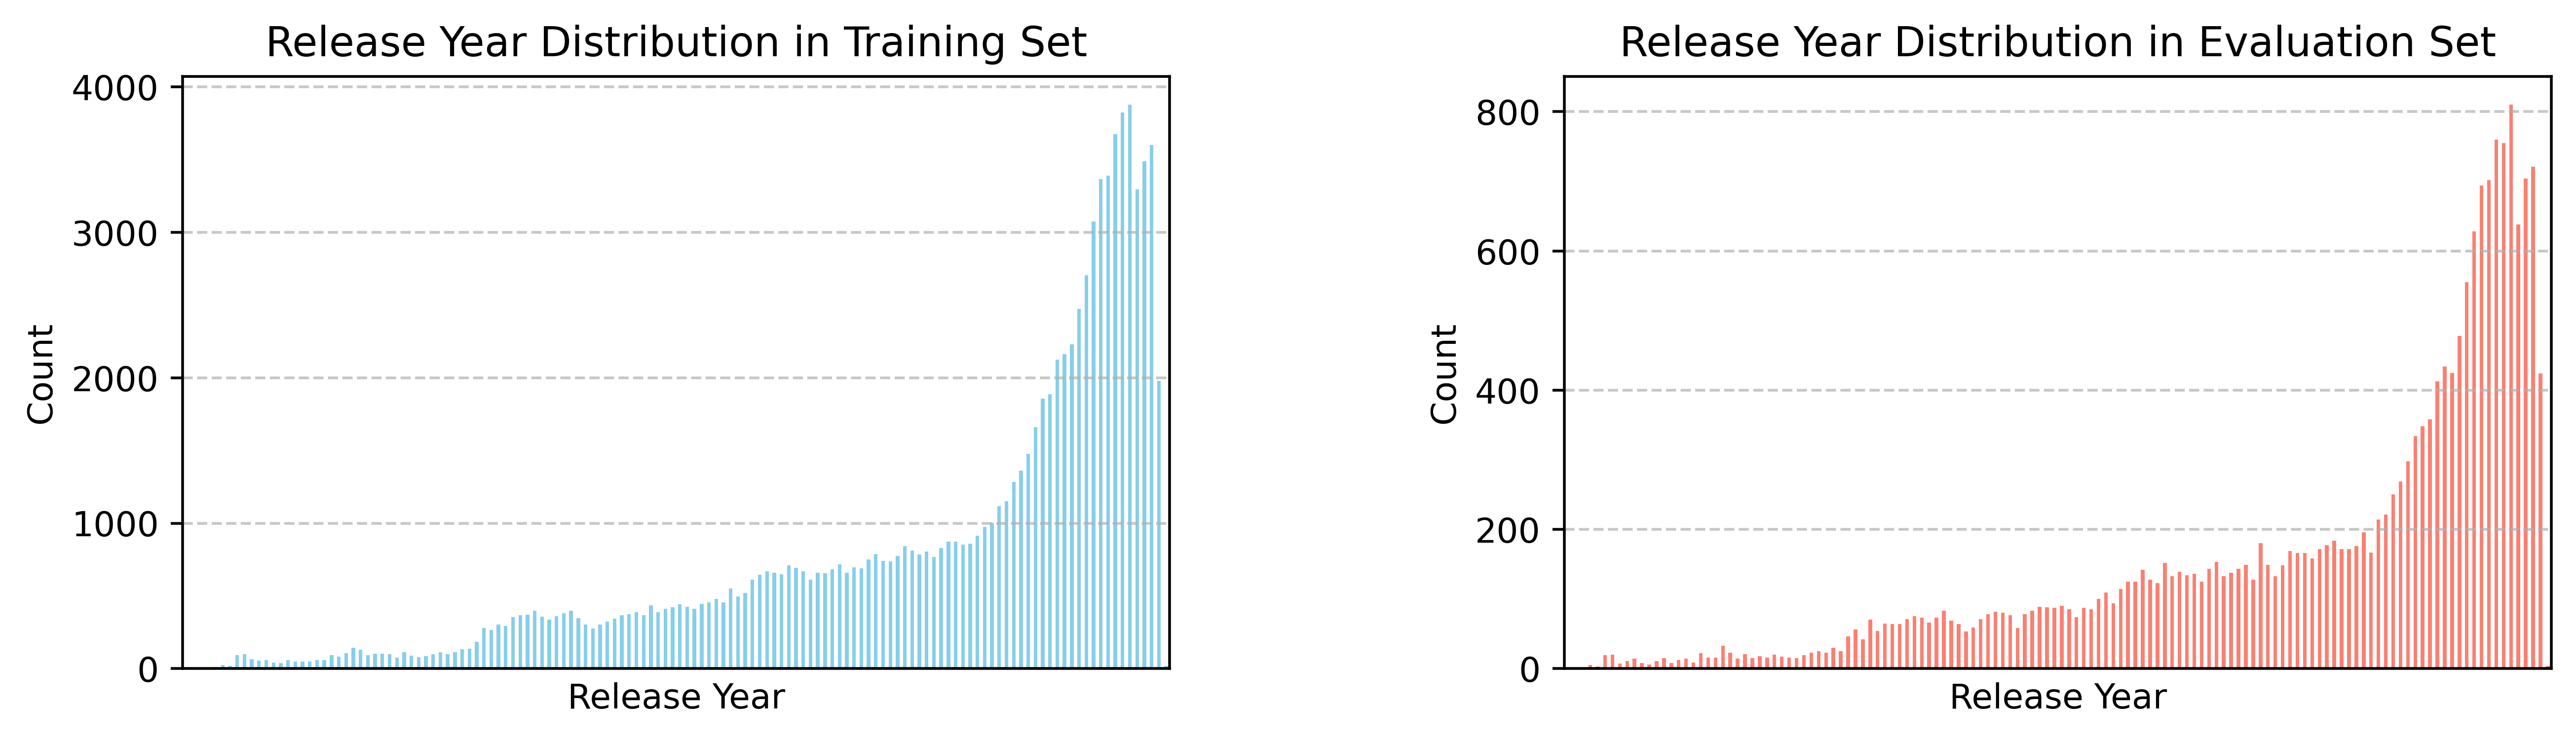

In [ ]:
# distribution of years in training and evaluation set
year_train = train['release_year'].value_counts().sort_index()
year_eval = evaluate['release_year'].value_counts().sort_index()

plt.figure(figsize=(12, 3), dpi=500)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.subplot(1, 2, 1)
year_train.plot(kind='bar', color='skyblue')
plt.title('Release Year Distribution in Training Set')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(labelbottom = False, bottom = False)

plt.subplot(1, 2, 2)
year_eval.plot(kind='bar', color='salmon')
plt.title('Release Year Distribution in Evaluation Set')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tick_params(labelbottom = False, bottom = False)

plt.show()

<Figure size 1000x600 with 0 Axes>

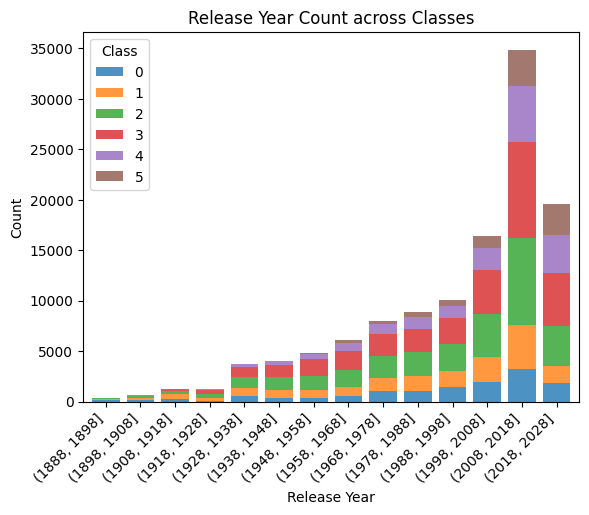

In [ ]:
# the bin size
bin_width = 10

# cut release_year into bins and store in a new column
concat_df['release_year_bin'] = pd.cut(concat_df['release_year'], bins=range(concat_df['release_year'].min(), concat_df['release_year'].max() + bin_width, bin_width))

# group by the binned release_year and rate_category and count the occurrences
class_year_counts = concat_df.groupby(['release_year_bin', 'rate_category']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
# stacked bar chart
class_year_counts.plot(kind='bar', stacked=True, width=0.8, alpha=0.8)
plt.title('Release Year Count across Classes')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Class')
plt.show()

In [ ]:
concat_df['release_year_bin']

0        (2008, 2018]
1        (1968, 1978]
2        (2008, 2018]
3        (2008, 2018]
4        (1898, 1908]
             ...     
19995    (1998, 2008]
19996    (1988, 1998]
19997    (2018, 2028]
19998    (1988, 1998]
19999    (1978, 1988]
Name: release_year_bin, Length: 120000, dtype: category
Categories (14, interval[int64, right]): [(1888, 1898] < (1898, 1908] < (1908, 1918] < (1918, 1928] <
                                          ... < (1988, 1998] < (1998, 2008] <
                                          (2008, 2018] < (2018, 2028]]

# Test set

In [ ]:
test = pd.read_csv("TMDB_test.csv")
# extract the text features
te = test[['title', 'overview', 'tagline', 'production_companies']]

# fill the missing value with blank
te.fillna('', inplace = True)
test.head()

,id,title,release_year,overview,tagline,runtime,budget,revenue,adult,original_language,...,product_of_France,product_of_Germany,product_of_India,product_of_Italy,product_of_Japan,product_of_Spain,product_of_UK,product_of_USA,product_of_other_countries,vote_count
0,68793,Grand Hotel,2008,"Handsome, wealthy neurosurgeon Philip Morawski...",NaN,101,0,0,False,pl,...,0,0,0,0,0,0,0,0,1,19
1,25867,De Dana Dan,2009,Two down on their luck men tries to kidnap a w...,NaN,166,8000000,9000000,False,hi,...,0,0,1,0,0,0,0,0,0,63
2,928334,Julia's Lover,2022,Paralyzed from the waist down after an acciden...,NaN,106,0,0,False,pt,...,0,0,0,0,0,0,0,0,1,2
3,252028,Halfway,2014,"Stef moved to a new home, but there is another...",NaN,0,0,0,False,nl,...,0,0,0,0,0,0,0,0,1,8
4,541398,Precious,2018,Upon learning that a planned school trip was p...,NaN,27,0,0,False,bs,...,0,0,0,0,0,0,0,0,1,1


In [ ]:
te['text'] = te['title'] + ' ' + te['overview'] + ' ' + te['tagline'] + ' ' + te['production_companies']
te = te['text']
te = te.reset_index().drop(columns = ['index'])
te.columns = ["text"]

# apply cleaning
te['text'] = te['text'].apply(lambda x: clean_text(x))
te.head()

,text
0,grand hotel handsome wealthy neurosurgeon phil...
1,de dana dan two luck men try kidnap wealthy bu...
2,julia lover paralyzed waist accident cássio re...
3,halfway stef moved new home another man home t...
4,precious upon learning planned school trip pos...


In [ ]:
# filtering the words which appear less frequently
te['text'] = te['text'].apply(lambda x: keep_word(x, vocab))
te.head()

,text
0,grand hotel handsome wealthy neurosurgeon phil...
1,de dana dan two luck men try kidnap wealthy bu...
2,julia lover paralyzed waist accident relations...
3,halfway moved new home another man home theo t...
4,precious upon learning planned school trip pos...


In [ ]:
# use the previous vectorizer to vectorize the text
te_text = tfidf_vect.transform(te['text'])
print(te_text.shape)

(20000, 30121)


In [ ]:
# Transform the test data using the fitted encoder
te_year = onehot_encoder.transform(test[['release_year']])

# Convert the encoded array into a DataFrame
te_year_df = pd.DataFrame(te_year, columns=onehot_encoder.get_feature_names_out(['release_year']))
te_year_df.head()

,release_year_1888,release_year_1890,release_year_1891,release_year_1892,release_year_1893,release_year_1894,release_year_1895,release_year_1896,release_year_1897,release_year_1898,...,release_year_2015,release_year_2016,release_year_2017,release_year_2018,release_year_2019,release_year_2020,release_year_2021,release_year_2022,release_year_2023,release_year_2024
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
te_year_mtx = scipy.sparse.csr_matrix(te_year_df)
X_test = hstack((te_text, te_year_mtx))
# X_test includes release_year and te_text includes pure text features
print(X_test.shape, te_text.shape)

(20000, 30257) (20000, 30121)


In [ ]:
id = test['id']

# making prediction use the pre-trained models
y_pred1 = lgr1.predict(te_text)
y_pred2 = mlp_clf1.predict(te_text)

# convert arrays to DataFrame
pred1 = pd.DataFrame({'rate_category': y_pred1})
pred2 = pd.DataFrame({'rate_category': y_pred2})

# concat the df with id
df1 = pd.concat([id, pred1], axis=1)
df2 = pd.concat([id, pred2], axis=1)

# save as csv file
df1.to_csv("pred1.csv", index=False)
df2.to_csv("pred2.csv", index=False)